# Recipe Recommendation with Content-Based and Collaborative Filtering

## The Recipe Dataset

## Data Preparation
Let's load this data into Python. I will load the dataset with Pandas onto Dataframes **ratings**, **users**, and **recipes**. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
# Reading ratings file
ratings = pd.read_csv('ratings.csv')

# Reading users file
users = pd.read_csv('users.csv')

# Reading movies file
recipes = pd.read_csv('allrecipes.csv')

### Ratings Dataset

In [3]:
# Check the top 5 rows
ratings.head()

,user_id,recipe_id,rating,user_emb_id,recipe_emb_id
0,1,1,2,0,0
1,1,2,2,0,1
2,1,3,3,0,2
3,1,4,4,0,3
4,1,5,1,0,4


In [4]:
# Check the file info
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   user_id        105 non-null    int64
 1   recipe_id      105 non-null    int64
 2   rating         105 non-null    int64
 3   user_emb_id    105 non-null    int64
 4   recipe_emb_id  105 non-null    int64
dtypes: int64(5)
memory usage: 4.2 KB
None


### Users Dataset

In [5]:
# Check the top 5 rows
users.head()

,user_id,gender,age_desc,height,weight,diets,allergies,disliked_ingredients,favorite_cuisines,goals,cooking_level
0,1,M,18-24,180,75,NaN,NaN,pork,Chinese,save time,beginner
1,2,M,18-24,190,90,NaN,apple,pork,Chinese,eat healthy,beginner
2,3,M,18-24,182,80,NaN,milk,lamb,Chinese,save money,medium
3,4,M,18-24,175,65,NaN,NaN,broccoli,Chinese,save money,beginner
4,5,F,50-60,167,60,NaN,NaN,NaN,Chinese,eat healthy,expert


In [6]:
# Check the file info
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               7 non-null      int64  
 1   gender                7 non-null      object 
 2   age_desc              7 non-null      object 
 3   height                7 non-null      int64  
 4   weight                7 non-null      int64  
 5   diets                 0 non-null      float64
 6   allergies             2 non-null      object 
 7   disliked_ingredients  6 non-null      object 
 8   favorite_cuisines     7 non-null      object 
 9   goals                 7 non-null      object 
 10  cooking_level         7 non-null      object 
dtypes: float64(1), int64(3), object(7)
memory usage: 744.0+ bytes
None


### Recipes Dataset

In [7]:
recipes = recipes[['recipe_id', 'recipe_name', 'servings', 'group_name', 'calories',
        'protein', 'carbohydrates', 'fat', 'ingredients']]
# Check the top 5 rows
recipes.head()

,recipe_id,recipe_name,servings,group_name,calories,protein,carbohydrates,fat,ingredients
0,1,Breakfast Cups,18,"not known, breakfast",190.4,8.3,13.6,11.4,"['cooking spray', '18 biscuit (2-1/2"" dia)s re..."
1,2,Easy Shakshuka,4,"not known, breakfast",293.5,13.1,40.9,9.4,"['1 tablespoon olive oil', '2 cloves garlic, m..."
2,3,Lemon-Ricotta Cornmeal Waffles,4,"not known, breakfast",406.1,12.3,52.2,16.6,"['1 cup all-purpose flour', '½ cup cornmeal', ..."
3,4,Bacon and Egg Tacos,6,"not known, breakfast",435.7,18.9,40.5,22.0,"['6 large eggs eggs', '¼ cup crumbled cooked b..."
4,5,Eggs Benedict Casserole,10,"not known, breakfast",281.3,17.5,21.2,14.1,"['cooking spray', '8 large eggs', '2 cups milk..."


In [8]:
# Check the file info
print(recipes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27865 entries, 0 to 27864
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recipe_id      27865 non-null  int64  
 1   recipe_name    27865 non-null  object 
 2   servings       27865 non-null  int64  
 3   group_name     27865 non-null  object 
 4   calories       27865 non-null  float64
 5   protein        27865 non-null  float64
 6   carbohydrates  27865 non-null  float64
 7   fat            27865 non-null  float64
 8   ingredients    27865 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 1.9+ MB
None


This dataset contains attributes of the 27865 recipes.

## Data Exploration
### Recipe Names
Are there certain words that feature more often in Recipe Names? I'll attempt to figure this out using a word-cloud visualization.

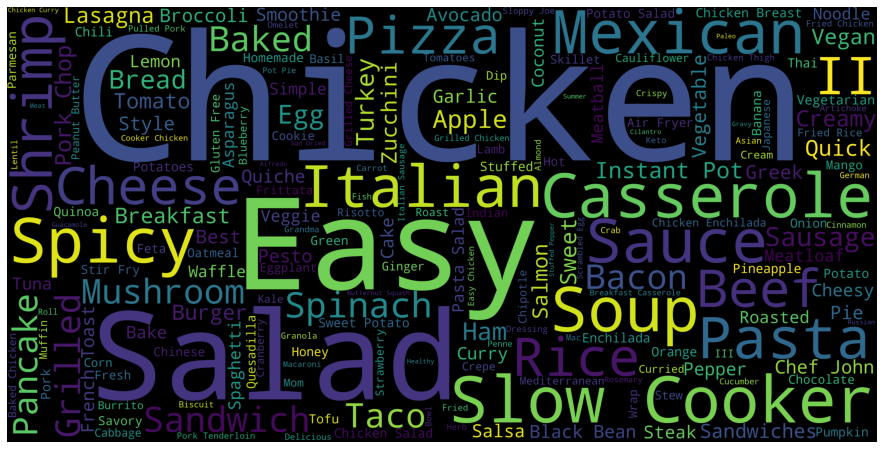

In [9]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the recipe titles
recipes['recipe_name'] = recipes['recipe_name'].fillna("").astype('str')
title_corpus = ' '.join(recipes['recipe_name'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

I can recognize that *Chicken*, *Salad*, *Rice*, *Spicy*, etc. are among the most commonly occuring words.

### Ratings
Next I want to examine the **rating** further. Let's take a look at its summary statistics and distribution.

In [10]:
# Get summary statistics of rating
ratings['rating'].describe()

count    105.000000
mean       2.704762
std        1.386222
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: rating, dtype: float64

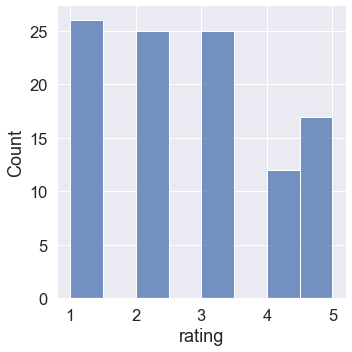

In [11]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.displot(ratings['rating'].fillna(ratings['rating'].median()))

In [12]:
# Join all 3 files into one dataframe
dataset = pd.merge(pd.merge(recipes, ratings),users)
# Display 20 recipes with highest ratings
'''Add new features!!!!!!!!!! eg. genres: extract features by using ingredient networks'''
dataset[['recipe_name','group_name','rating','ingredients']].sort_values('rating', ascending=False).head(20)

,recipe_name,group_name,rating,ingredients
52,Strawberry Oatmeal Breakfast Smoothie,"not known, breakfast",5,"['1 cup soy milk', '½ cup rolled oats', '1 ban..."
85,Farm Fresh Zucchini Cranberry Nut Muffins,"not known, breakfast",5,"['6 tablespoons all-purpose flour', '¼ cup bro..."
47,Lemon-Ricotta Cornmeal Waffles,"not known, breakfast",5,"['1 cup all-purpose flour', '½ cup cornmeal', ..."
48,Bacon and Egg Tacos,"not known, breakfast",5,"['6 large eggs eggs', '¼ cup crumbled cooked b..."
59,Waffles I,"not known, breakfast",5,"['2 large eggs eggs', '2 cups all-purpose flou..."
68,Mom's Apple Fritters,"not known, breakfast",5,"['1 quart vegetable oil for deep-frying', '1\u..."
78,Bacon and Egg Tacos,"not known, breakfast",5,"['6 large eggs eggs', '¼ cup crumbled cooked b..."
79,Eggs Benedict Casserole,"not known, breakfast",5,"['cooking spray', '8 large eggs', '2 cups milk..."
83,Mom's Apple Fritters,"not known, breakfast",5,"['1 quart vegetable oil for deep-frying', '1\u..."
82,Strawberry Oatmeal Breakfast Smoothie,"not known, breakfast",5,"['1 cup soy milk', '½ cup rolled oats', '1 ban..."


### Group Names
The genres variable will surely be important while building the recommendation engines since it describes the content of the recipe.

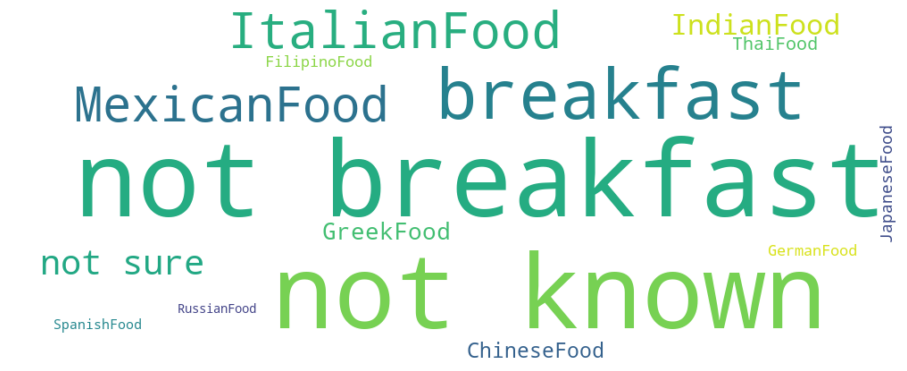

In [13]:
# Make a census of the group_name keywords
group_name_labels = set()
for s in recipes['group_name'].str.split(',').values:
    group_name_labels = group_name_labels.union(set(s))

# Function that counts the number of times each of the group_name keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split(','):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of group_name keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(recipes, 'group_name', group_name_labels)
keyword_occurences[:5]

# Define the dictionary used to produce the genre wordcloud
group_names = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    group_names[s[0]] = s[1]

# Create the wordcloud
group_name_wordcloud = WordCloud(width=1000,height=400, background_color='white')
group_name_wordcloud.generate_from_frequencies(group_names)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(group_name_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Ingredients

In [14]:
for i in range(len(recipes['ingredients'])):
    recipes['ingredients'][i] = re.sub(r'[^a-zA-Z0-9,.\'!?]+',' ', recipes['ingredients'][i])
    recipes['ingredients'][i] = recipes['ingredients'][i].replace("'",'')
    temp = []
    for s in recipes['ingredients'][i].split(','):
        temp.append(s.strip())
    recipes['ingredients'][i] = '|'.join(temp)

/Users/yangzeyu/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yangzeyu/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yangzeyu/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

### Genres

In [15]:
'''Need to add new features'''
# # Make a census of the genre keywords
# genre_labels = set()
# for s in movies['genres'].str.split('|').values:
#     genre_labels = genre_labels.union(set(s))

# # Function that counts the number of times each of the genre keywords appear
# def count_word(dataset, ref_col, census):
#     keyword_count = dict()
#     for s in census: 
#         keyword_count[s] = 0
#     for census_keywords in dataset[ref_col].str.split('|'):        
#         if type(census_keywords) == float and pd.isnull(census_keywords): 
#             continue        
#         for s in [s for s in census_keywords if s in census]: 
#             if pd.notnull(s): 
#                 keyword_count[s] += 1
#     #______________________________________________________________________
#     # convert the dictionary in a list to sort the keywords by frequency
#     keyword_occurences = []
#     for k,v in keyword_count.items():
#         keyword_occurences.append([k,v])
#     keyword_occurences.sort(key = lambda x:x[1], reverse = True)
#     return keyword_occurences, keyword_count

# # Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
# keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
# keyword_occurences[:5]

# # Define the dictionary used to produce the genre wordcloud
# genres = dict()
# trunc_occurences = keyword_occurences[0:18]
# for s in trunc_occurences:
#     genres[s[0]] = s[1]

# # Create the wordcloud
# genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
# genre_wordcloud.generate_from_frequencies(genres)

# # Plot the wordcloud
# f, ax = plt.subplots(figsize=(16, 8))
# plt.imshow(genre_wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

'Need to add new features'

## Types of Recommendation Engines

### 1. Content-Based
The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

A content based recommender works with data that the user provides, either explicitly movie ratings for the MovieLens dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

### 2. Collaborative Filtering
The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that. 

For instance, if user A likes recipes 1, 2, 3 and user B likes recipes 2,3,4, then they have similar interests and A should like movie 4 and B should like movie 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

In general, collaborative filtering is the workhorse of recommender engines. The algorithm has a very interesting property of being able to do feature learning on its own, which means that it can start to learn for itself what features to use. It can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. In this post, I'll only focus on the Memory-Based Collaborative Filtering technique.

![rec-systems](images/rec-systems.png)

## Content-Based Recommendation Model
### Theory
The concepts of **Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “**the results of latest European Socccer games**” on Google. It is certain that “**the**” will occur more frequently than “**soccer games**” but the relative importance of **soccer games** is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

Below is the equation to calculate the TF-IDF score:
![tfidf](images/tfidf.jpg)

After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the **Vector Space Model** which computes the proximity based on the angle between the vectors. In this model, each item is stored as a vector of its attributes (which are also vectors) in an **n-dimensional space** and the angles between the vectors are calculated to **determine the similarity between the vectors**. Next, the user profile vectors are also created based on his actions on previous attributes of items and the similarity between an item and a user is also determined in a similar way.

![vector-space](images/vector_space.png)

Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. The ultimate reason behind using cosine is that the **value of cosine will increase with decreasing value of the angle** between which signifies more similarity. The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

### Implementation
With all that theory in mind, I am going to build a Content-Based Recommendation Engine that computes similarity between recipes based on movie genres. It will suggest recipes that are most similar to a particular movie based on its genre. To do so, I will make use of the file **recipes.csv**.

In [16]:
'''Need Genres'''

'Need Genres'

In [17]:
# Break up the big string into a string array
recipes['group_name'] = recipes['group_name'].str.split(',')
recipes['ingredients'] = recipes['ingredients'].str.split('|')
feature = recipes['group_name'] + recipes['ingredients']
print(feature)

0        [not known,  breakfast, cooking spray, 18 bisc...
1        [not known,  breakfast, 1 tablespoon olive oil...
2        [not known,  breakfast, 1 cup all purpose flou...
3        [not known,  breakfast, 6 large eggs eggs, cup...
4        [not known,  breakfast, cooking spray, 8 large...
                               ...                        
27860    [GreekFood,  breakfast, 2 u2009 cups all purpo...
27861    [GreekFood,  not breakfast, 4 piece blank s sk...
27862    [GreekFood,  breakfast, 8 ounces crumbled feta...
27863    [GreekFood,  not breakfast, 1 pound medium shr...
27864    [GreekFood,  not sure, 2 cups unsalted butter,...
Length: 27865, dtype: object


In [18]:
# Convert to string value
feature = feature.fillna("").astype('str')

I do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively. In order to do so, I'll use **TfidfVectorizer** function from **scikit-learn**, which transforms text to feature vectors that can be used as input to estimator.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(feature)
tfidf_matrix.shape

(27865, 60970)

I will be using the **[Cosine Similarity](https://masongallo.github.io/machine/learning,/python/2016/07/29/cosine-similarity.html)** to calculate a numeric quantity that denotes the similarity between two recipes. Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's **linear_kernel** instead of cosine_similarities since it is much faster.

In [20]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.0258545 , 0.07954703, 0.06943311],
       [0.0258545 , 1.        , 0.0452722 , 0.06364657],
       [0.07954703, 0.0452722 , 1.        , 0.10838118],
       [0.06943311, 0.06364657, 0.10838118, 1.        ]])

I now have a pairwise cosine similarity matrix for all the recipes in the dataset. The next step is to write a function that returns the 20 most similar recipes based on the cosine similarity score.

In [21]:
# Build a 1-dimensional array with recipe names
recipe_name = recipes['recipe_name']
indices = pd.Series(recipes.index, index=recipes['recipe_name'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(name):
    idx = indices[name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    recipe_indices = [i[0] for i in sim_scores]
    return recipe_name.iloc[recipe_indices]

Let's try and get the top recommendations for a few recipes and see how good the recommendations are.

In [22]:
genre_recommendations('Breakfast Cups').head(20)

3629                             AB's Breakfast Pizza
971                             Dad's Breakfast Pizza
2527                             Paleo Scrambled Eggs
2077                               Breakfast Cupcakes
175              Laura's Breadless Fried Egg Sandwich
657                                 Baked Omelet Roll
432                 Sausage, Egg, and Cheese Scramble
233                              Muffin Pan Frittatas
597                          Microwave Scrambled Eggs
4238                          Easy Breakfast Cupcakes
1958                       Quick Creamed Ham and Eggs
1721    Cheesy Sausage and Potato Breakfast Casserole
3336                Super Easy Breakfast Sausage Loaf
2640              Emma's Humongous Yorkshire Puddings
1731                       Grilled Cheese Brunch Bake
4443                       Individual Baked Frittatas
403                                 Breakfast Pizza I
918                                   Breakfast Pizza
1686       Biscuits and Saus

In [23]:
genre_recommendations('Chef John\'s Chinese Scallion Pancakes').head(20)

19552                                    Green Onion Cakes
10712                                    Green Onion Cakes
2984                                          Berber Bread
19657                          Chinese Hand-Pulled Noodles
19488                           Pan-Fried Chinese Pancakes
20259                                         Roomali Roti
19743                                  Green Onion Pancake
19766                Traditional Chinese Scallion Pancakes
19724            Cong You Bing (Chinese Scallion Pancakes)
1512                                 Spiced Maple Pancakes
20103                                 Indian Chapati Bread
26906                                Deep Dish Pizza Dough
11535                       Poor Man's Chicken Fried Steak
2317                            Cinnamon Pancakes in a Jar
1781                                    Date and Nut Bread
20234                                   Indian Sweet Bread
353                            Extra-Yummy Fluffy Pancak

## Collaborative Filtering Recommendation Model
The content based engine suffers from some severe limitations. It is only capable of suggesting recipes which are close to a certain recipe. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a recipe will receive the same recommendations for that recipe, regardless of who she/he is.

Therefore, in this section, I will use Memory-Based Collaborative Filtering to make recommendations to recipe users. The technique is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

### Theory
There are 2 main types of memory-based collaborative filtering algorithms:
1. **User-User Collaborative Filtering**: Here we find look alike users based on similarity and recommend recipes which first user’s look-alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.
2. **Item-Item Collaborative Filtering**: It is quite similar to previous algorithm, but instead of finding user's look-alike, we try finding recipe's look-alike. Once we have recipe's look-alike matrix, we can easily recommend alike recipes to user who have rated any recipe from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of recipes, recipe-recipe look alike matrix is fixed over time.

![user_item_cf](images/user_item_cf.jpg)

In either scenario, we builds a similarity matrix. For user-user collaborative filtering, the **user-similarity matrix** will consist of some distance metrics that measure the similarity between any two pairs of users. Likewise, the **item-similarity matrix** will measure the similarity between any two pairs of items.

There are 3 distance similarity metrics that are usually used in collaborative filtering:
1. **Jaccard Similarity**:
    * Similarity is based on the number of users which have rated item A and B divided by the number of users who have rated either A or B
    * It is typically used where we don’t have a numeric rating but just a boolean value like a product being bought or an add being clicked

2. **Cosine Similarity**: (as in the Content-Based system)
    * Similarity is the cosine of the angle between the 2 vectors of the item vectors of A and B
    * Closer the vectors, smaller will be the angle and larger the cosine

3. **Pearson Similarity**:
    * Similarity is the pearson coefficient between the two vectors.

For the purpose of diversity, I will use **Pearson Similarity** in this implementation.

### Implementation
I will use the file **ratings.csv** first as it contains User ID, Recipe IDs and Ratings. These three elements are all I need for determining the similarity of the users based on their ratings for a particular recipe.

First I do some quick data processing:

In [24]:
# Fill NaN values in user_id and movie_id column with 0
ratings['user_id'] = ratings['user_id'].fillna(0)
ratings['recipe_id'] = ratings['recipe_id'].fillna(0)

# Replace NaN values in rating column with average of all values
ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())

In [25]:
# Randomly sample 1% of the ratings dataset
# small_data = ratings.sample(frac=0.02)
small_data = ratings
# Check the sample info
print(small_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   user_id        105 non-null    int64
 1   recipe_id      105 non-null    int64
 2   rating         105 non-null    int64
 3   user_emb_id    105 non-null    int64
 4   recipe_emb_id  105 non-null    int64
dtypes: int64(5)
memory usage: 4.2 KB
None


In [31]:
small_data

,user_id,recipe_id,rating,user_emb_id,recipe_emb_id
0,1,1,2,0,0
1,1,2,2,0,1
2,1,3,3,0,2
3,1,4,4,0,3
4,1,5,1,0,4
...,...,...,...,...,...
100,7,11,5,6,10
101,7,12,4,6,11
102,7,13,2,6,12
103,7,14,2,6,13


In [29]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(small_data, test_size=0.2)

In [43]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.values[:,[0,1,2]]
test_data_matrix = test_data.values[:,[0,1,2]]

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(84, 3)
(21, 3)


In [44]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[1.         0.69961438 0.9845525  0.98687258]
 [0.69961438 1.         0.81273527 0.80574863]
 [0.9845525  0.81273527 1.         0.9997618 ]
 [0.98687258 0.80574863 0.9997618  1.        ]]


In [45]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[ 1.         -0.00988041  0.14000556]
 [-0.00988041  1.          0.04432088]
 [ 0.14000556  0.04432088  1.        ]]


In [46]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [47]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [48]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.749487244834386
Item-based CF RMSE: 3.9975136526375903


In [49]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 1.7842539705604525
Item-based CF RMSE: 0.42179587718059675
